# Crime Analysis in Chicago

- Is Trump telling the truth?
- What can we gather about the crimes that may actually help us better allocate resources and reduce crime in chicago?



## PySpark environment setup

In [30]:
import findspark
findspark.init()

In [31]:
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.getOrCreate()

## Data source and DataFrame setup

In [32]:
crimesDF = spark.read \
                .option("inferSchema", "true") \
                .option("header", "true") \
                .csv("Chicago_Crimes_2012_to_2017.csv") \
                .cache()

## Data set metadata analysis

In [33]:
from IPython.display import display, Markdown
crimesDF.printSchema()
display(Markdown("This DataFrame has **%d rows**." % crimesDF.count()))

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: double (nullable = true)
 |-- Ward: double (nullable = true)
 |-- Community Area: double (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



This DataFrame has **1456714 rows**.

In [147]:
# Let's examine a row from our dataframe.
display(crimesDF.take(1))

[Row(Date='05/03/2016 11:40:00 PM', Year=2016, Location Description='APARTMENT', Domestic=True, Arrest=True, Primary Type='BATTERY', Community Area=29.0)]


##  Let's do some basic profiling to understand our dataset

In [36]:
# Checking our important columns in our dataset for nulls.
from pyspark.sql.functions import when, count, col, countDistinct, desc, first, lit
crimesDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["Date", "Year", "Arrest", "Location Description", "Community Area", "Primary Type", "Domestic"]]).show()

# Our most important value doesn't have any nulls, we have 40 in community area and 1658 in Location but considering the size of our data thats almost nothing.

Checking for nulls on some important columns in our analysis:
+----+----+------+--------------------+--------------+------------+--------+
|Date|Year|Arrest|Location Description|Community Area|Primary Type|Domestic|
+----+----+------+--------------------+--------------+------------+--------+
|   0|   0|     0|                1658|            40|           0|       0|
+----+----+------+--------------------+--------------+------------+--------+



In [37]:
# Checking amount of distinct values in some of our columns.
crimesDF.select([countDistinct(c).alias(c) for c in ["Location Description", "Community Area", "Primary Type"]]).show()

Checking amount of distinct values in some columns:
+--------------------+--------------+------------+
|Location Description|Community Area|Primary Type|
+--------------------+--------------+------------+
|                 142|            78|          33|
+--------------------+--------------+------------+



In [148]:
# Let's extract the columns we're gonnq use and make things more manageable
crimesDF = crimesDF.select("Date", "Year", "Location Description", "Domestic", "Arrest", "Primary Type", "Community Area").cache()
crimesDF.show()

+--------------------+----+--------------------+--------+------+--------------------+--------------+
|                Date|Year|Location Description|Domestic|Arrest|        Primary Type|Community Area|
+--------------------+----+--------------------+--------+------+--------------------+--------------+
|05/03/2016 11:40:...|2016|           APARTMENT|    true|  true|             BATTERY|          29.0|
|05/03/2016 09:40:...|2016|           RESIDENCE|    true| false|             BATTERY|          42.0|
|05/03/2016 11:31:...|2016|              STREET|   false| false|PUBLIC PEACE VIOL...|          25.0|
|05/03/2016 10:10:...|2016|            SIDEWALK|   false| false|             BATTERY|          25.0|
|05/03/2016 10:00:...|2016|           RESIDENCE|    true| false|               THEFT|          25.0|
|05/03/2016 10:35:...|2016|              STREET|   false| false|             BATTERY|          44.0|
|05/03/2016 10:30:...|2016|CHA HALLWAY/STAIR...|   false| false|             BATTERY|      

## Is Trump telling the truth?

In [39]:
crimesDF.groupby("Year").count().orderBy("Year").show()

+----+------+
|Year| count|
+----+------+
|2012|335670|
|2013|306703|
|2014|274527|
|2015|262995|
|2016|265462|
|2017| 11357|
+----+------+



<AxesSubplot:xlabel='Year'>

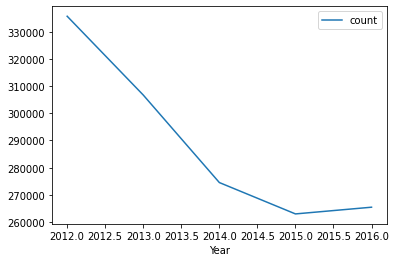

In [40]:
pdf = crimesDF.where(col("Year") < 2017).groupby("Year").count().orderBy("Year").toPandas()
pdf.plot.line(x="Year", y="count")

In [42]:
# the percentage of arrests did drop significantly in 2016
length = crimesDF.groupby("Year").count().orderBy("Year").toPandas()
arrestsDF = crimesDF.where(col("Arrest") == 1).groupby("Year").count().orderBy("Year").toPandas()
arrestsDF["count"] = arrestsDF["count"]/length["count"]*100
arrestsDF = arrestsDF[:5]
arrestsDF

,Year,count
0,2012,26.964280
1,2013,28.111561
2,2014,28.797532
3,2015,26.387194
4,2016,18.980494


<AxesSubplot:xlabel='Year'>

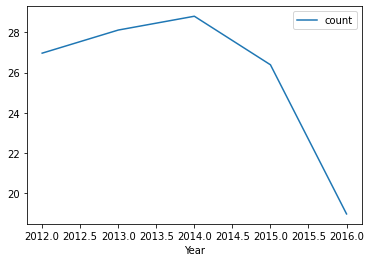

In [43]:
arrestsDF.plot.line(x="Year", y="count")

## When are these crimes happening?

In [52]:
import datetime
from pyspark.sql.functions import to_timestamp, year, month, dayofmonth, hour
timeDF = crimesDF.select("Date").withColumn("timestamp", to_timestamp("Date", "MM/dd/yyyy hh:mm:ss a")).cache()
timeDF.show()

+--------------------+-------------------+
|                Date|          timestamp|
+--------------------+-------------------+
|05/03/2016 11:40:...|2016-05-03 23:40:00|
|05/03/2016 09:40:...|2016-05-03 21:40:00|
|05/03/2016 11:31:...|2016-05-03 23:31:00|
|05/03/2016 10:10:...|2016-05-03 22:10:00|
|05/03/2016 10:00:...|2016-05-03 22:00:00|
|05/03/2016 10:35:...|2016-05-03 22:35:00|
|05/03/2016 10:30:...|2016-05-03 22:30:00|
|05/03/2016 09:30:...|2016-05-03 21:30:00|
|05/03/2016 04:00:...|2016-05-03 16:00:00|
|05/03/2016 10:30:...|2016-05-03 22:30:00|
|05/03/2016 09:44:...|2016-05-03 21:44:00|
|05/03/2016 11:11:...|2016-05-03 23:11:00|
|05/03/2016 05:30:...|2016-05-03 17:30:00|
|05/03/2016 09:00:...|2016-05-03 09:00:00|
|05/03/2016 10:08:...|2016-05-03 22:08:00|
|05/03/2016 04:00:...|2016-05-03 16:00:00|
|05/03/2016 09:45:...|2016-05-03 21:45:00|
|05/03/2016 10:00:...|2016-05-03 22:00:00|
|05/03/2016 08:00:...|2016-05-03 20:00:00|
|05/03/2016 11:00:...|2016-05-03 23:00:00|
+----------

In [55]:
# Let's check what's happening on different months
monthDF = timeDF.select(month("timestamp").alias("Month")).groupby("Month").count().orderBy("Month")
monthDF.show() 

+-----+------+
|Month| count|
+-----+------+
|    1|123809|
|    2| 98073|
|    3|119010|
|    4|118064|
|    5|129735|
|    6|130575|
|    7|135762|
|    8|133738|
|    9|124067|
|   10|123571|
|   11|111834|
|   12|108476|
+-----+------+



<AxesSubplot:xlabel='Month'>

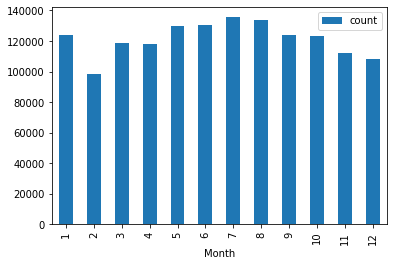

In [56]:
pmonthDF = monthDF.toPandas()
pmonthDF.plot.bar(x="Month", y="count")


In [57]:
# Let's check which hours of the day have the most crimes
hourDF = timeDF.select(hour("timestamp").alias("Hour")).groupby("Hour").count().orderBy("Hour")
hourDF.show()

+----+-----+
|Hour|count|
+----+-----+
|   0|71288|
|   1|43771|
|   2|37520|
|   3|31217|
|   4|23325|
|   5|20233|
|   6|24609|
|   7|34522|
|   8|50637|
|   9|67712|
|  10|65006|
|  11|67005|
|  12|83930|
|  13|69666|
|  14|73698|
|  15|79930|
|  16|76065|
|  17|75556|
|  18|82414|
|  19|84193|
+----+-----+
only showing top 20 rows



<AxesSubplot:xlabel='Hour'>

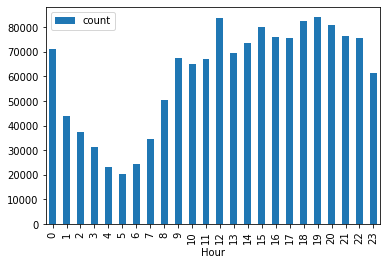

In [58]:
phourDF = hourDF.toPandas()
phourDF.plot.bar(x="Hour", y="count")

## What are the most common types of crimes?

In [90]:
primaryDF = crimesDF.groupby("Primary Type").count()
primaryDF.show()

+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|OFFENSE INVOLVING...| 11398|
|            STALKING|   828|
|PUBLIC PEACE VIOL...| 13122|
|           OBSCENITY|   187|
|NON-CRIMINAL (SUB...|     4|
|               ARSON|  2217|
|            GAMBLING|  2212|
|   CRIMINAL TRESPASS| 36912|
|             ASSAULT| 91289|
|      NON - CRIMINAL|    38|
|LIQUOR LAW VIOLATION|  1953|
| MOTOR VEHICLE THEFT| 61138|
|               THEFT|329460|
|             BATTERY|263700|
|             ROBBERY| 57313|
|            HOMICIDE|  2649|
|    PUBLIC INDECENCY|    62|
| CRIM SEXUAL ASSAULT|  6823|
|   HUMAN TRAFFICKING|    28|
|        INTIMIDATION|   662|
+--------------------+------+
only showing top 20 rows



<AxesSubplot:xlabel='Primary Type'>

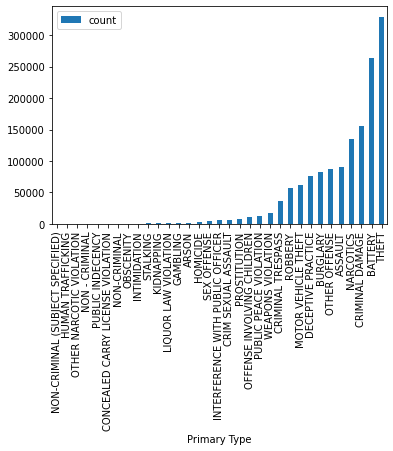

In [149]:
primaryPDF = primaryDF.toPandas()
primaryPDF = primaryPDF.sort_values(by=["count"])
primaryPDF.plot.bar(x="Primary Type", y="count")

In [92]:
# arrest ratios of all the crime types
primaryDF_arrests = crimesDF.where(col("Arrest")==1).groupby("Primary Type").count()
primaryPDF_arrests = primaryDF_arrests.toPandas()
primaryPDF["count"] = primaryPDF_arrests["count"]/primaryPDF["count"]*100
primaryPDF

,Primary Type,count
0,OFFENSE INVOLVING CHILDREN,15.976487
1,STALKING,17.149758
2,PUBLIC PEACE VIOLATION,75.819235
3,OBSCENITY,79.679144
4,NON-CRIMINAL (SUBJECT SPECIFIED),25.000000
5,ARSON,9.833108
6,GAMBLING,99.683544
7,CRIMINAL TRESPASS,70.240030
8,ASSAULT,23.385074
9,NON - CRIMINAL,15.789474


In [100]:
# Let's look how homicide has changed (one of trump's main talking points)
homicideDF = crimesDF.where(col("Primary Type")=="HOMICIDE").groupby("Year").count().orderBy("Year")
homicideDF.show()

+----+-----+
|Year|count|
+----+-----+
|2012|  503|
|2013|  422|
|2014|  424|
|2015|  497|
|2016|  772|
|2017|   31|
+----+-----+



<AxesSubplot:xlabel='Year'>

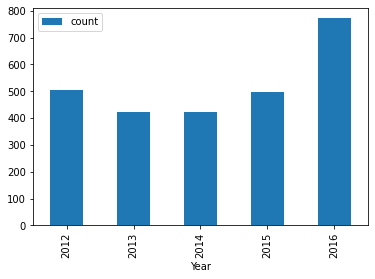

In [103]:
homicidePDF = homicideDF.toPandas()
homicidePDF = homicidePDF[:5]
homicidePDF.plot.bar(x="Year", y="count")

## Where are these crimes happening?

In [107]:
locationDF = crimesDF.groupby("Location Description").count().orderBy(desc("count"))
locationDF.show()

+--------------------+------+
|Location Description| count|
+--------------------+------+
|              STREET|330471|
|           RESIDENCE|233530|
|           APARTMENT|185023|
|            SIDEWALK|160891|
|               OTHER| 55774|
|PARKING LOT/GARAG...| 41768|
|               ALLEY| 31771|
|RESIDENTIAL YARD ...| 30645|
|  SMALL RETAIL STORE| 28803|
|SCHOOL, PUBLIC, B...| 25959|
|          RESTAURANT| 25872|
|    RESIDENCE-GARAGE| 25720|
|RESIDENCE PORCH/H...| 25511|
|VEHICLE NON-COMME...| 25104|
|    DEPARTMENT STORE| 20709|
|  GROCERY FOOD STORE| 15999|
|         GAS STATION| 15387|
|       PARK PROPERTY| 12270|
|       BAR OR TAVERN|  9871|
|COMMERCIAL / BUSI...|  7705|
+--------------------+------+
only showing top 20 rows



<AxesSubplot:xlabel='Location Description'>

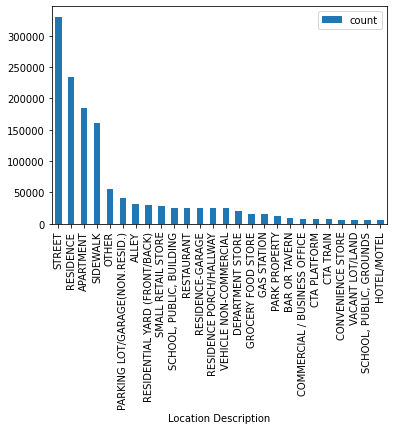

In [109]:
#This is a huge sample (1600+) so lets plot first 25
locationPDF = locationDF.toPandas()
locationPDF = locationPDF[:26]
locationPDF.plot.bar(x="Location Description", y="count")

In [131]:
# How many of these crimes are happening at home?
domestic = crimesDF.where(col("Domestic")==1).count()/crimesDF.count()*100
print("{}%".format(round(domestic, 2)), "of crimes seem to be happening at home.")

15.11% of crimes seem to be happening at home.


In [146]:
dom = crimesDF.where(col("Domestic")==1).count()
domestic_arrests = crimesDF.where((col("Domestic")==1) & (col("Arrest")==1)).count()/dom*100
print("{}%".format(round(domestic_arrests, 2)), "of domestic crimes end in arrests.")

19.4% of domestic crimes end in arrests.
